<a href="https://colab.research.google.com/github/Tepuy-A/Tesis-2/blob/main/Ising_DNN_Prueba_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Sin validación
GPU HIGH RAM   T4  RAM sistema 51 GB, RAM GPU 15 GB, Disco 201.2


*   Batch size = 64
*   Epoch = 50
*   Opt = SGD + momentum
*   learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
*   N_neurons = [1, 10, 100, 1000]


Cambio en la creación de datasets
cambio en el rango de learning rates

    
Critical accuracy 95




In [4]:
# Importa las bibliotecas necesarias
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pickle
import os
from urllib.request import urlopen
import matplotlib.pyplot as plt
import time


# Establece semillas
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# Define la URL del conjunto de datos y los nombres de los archivos

url_main = 'https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/'
data_file_name = "Ising2DFM_reSample_L40_T=All.pkl"
label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"

# Carga los datos y las etiquetas desde los archivos
data = pickle.load(urlopen(url_main + data_file_name))
data = np.unpackbits(data).reshape(-1, 1600) # Reformatea los datos
data = data.astype('int') # Convierte los datos a enteros
data[np.where(data == 0)] = -1 # Cambia los 0 a -1

labels = pickle.load(urlopen(url_main + label_file_name))
labels = to_categorical(labels, num_classes=2)  # Convierte las etiquetas a categóricas

# Divide los datos en conjuntos ordenados, críticos y desordenados
X_ordered = data[:70000, :]
Y_ordered = labels[:70000]

X_critical = data[70000:100000, :]
Y_critical = labels[70000:100000]

X_disordered = data[100000:, :]
Y_disordered = labels[100000:]

del data, labels # Libera memoria

# Crea conjuntos de entrenamiento y prueba combinando datos ordenados y desordenados
X = np.concatenate((X_ordered, X_disordered))
Y = np.concatenate((Y_ordered, Y_disordered))


# Divide en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# PRIMERA ETAPA

In [6]:
# Define una función para construir el modelo

def build_model(input_dim, neurons, learning_rate):
    model = Sequential()
    model.add(Dense(neurons, input_dim=input_dim, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))) # Agrega una capa densa con activación ReLU
    model.add(Dropout(0.5, seed=42)) # Agrega una capa de dropout para prevenir el sobreajuste
    model.add(Dense(2, activation='softmax')) # Agrega una capa de salida con activación softmax

    optimizer = SGD(learning_rate=learning_rate, momentum = 0.5) # Define el optimizador SGD con momentum
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) # Compila el modelo

    return model


In [7]:
# Define un generador de datos para el entrenamiento por lotes

from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size))) # Calcula el número de lotes

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size] # Obtiene un lote de datos
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size] # Obtiene las etiquetas correspondientes
        return batch_x, batch_y



# Crea generadores de datos para los conjuntos de entrenamiento, prueba y crítico
train_dataset = DataGenerator(X_train, Y_train, 64)
test_dataset = DataGenerator(X_test, Y_test, 64)
critical_dataset = DataGenerator(X_critical, Y_critical, 64)

In [8]:
# Define una función para evaluar el modelo
def evaluate_model(neurons, learning_rate, verbose=True):
    model = build_model(X_train.shape[1], neurons, learning_rate) # Construye el modelo

    # Limpiar la sesión de Keras para liberar memoria
    tf.keras.backend.clear_session()

    epoch_times = []  # Lista para almacenar los tiempos de cada época

    start_totaltime = time.time()  # Registrar el tiempo de inicio
    for epoch in range(50):
        start_time = time.time()  # Registrar el tiempo de inicio de la época
        model.fit(train_dataset, epochs=1, batch_size=64, verbose=verbose)  # Entrenar por una época
        epoch_time = time.time() - start_time  # Calcular el tiempo de la época
        epoch_times.append(epoch_time)
        if verbose:
            print(f'Epoch {epoch+1} time: {epoch_time} seconds')

    training_time = time.time() - start_totaltime  # Calcular el tiempo de entrenamiento

    average_epoch_time = sum(epoch_times) / len(epoch_times)  # Calcular el promedio

    # Evalúa el modelo en los conjuntos de entrenamiento, prueba y crítico
    train_loss, train_accuracy = model.evaluate(X_train, Y_train, verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
    critical_loss, critical_accuracy = model.evaluate(X_critical, Y_critical, verbose=0)

    if verbose:
        print(f'Train loss: {train_loss}, Train accuracy: {train_accuracy}')
        print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')
        print(f'Critical loss: {critical_loss}, Critical accuracy: {critical_accuracy}')
        print(f'Average epoch time: {average_epoch_time} seconds')
        print(f'Training time: {training_time} seconds')

    # Devuelve las métricas de evaluación y los tiempos
    return train_loss, train_accuracy, test_loss, test_accuracy, critical_loss, critical_accuracy, average_epoch_time, training_time

In [9]:
# Define una función para realizar una búsqueda de cuadrícula de hiperparámetros
def grid_search(verbose=True):
    N_neurons = [1, 10, 100, 1000] # Número de neuronas a probar
    learning_rates = [ 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]  # Tasas de aprendizaje a probar

    results_1 = {} # Diccionario para almacenar los resultados

    # Itera sobre las combinaciones de neuronas y tasas de aprendizaje
    for neurons in N_neurons:
        for lr in learning_rates:
            print(f'Training DNN with {neurons} neurons and SGD lr={lr}')

            # Evalúa el modelo con los hiperparámetros actuales
            train_loss_1, train_accuracy_1, test_loss_1, test_accuracy_1, critical_loss_1, critical_accuracy_1, average_epoch_time_1, training_time_1 = evaluate_model(neurons, lr, verbose)

            # Almacena los resultados en el diccionario
            results_1[(neurons, lr)] = {
                'train_loss_1': train_loss_1,
                'train_accuracy_1': train_accuracy_1,
                'test_loss_1': test_loss_1,
                'test_accuracy_1': test_accuracy_1,
                'critical_loss_1': critical_loss_1,
                'critical_accuracy_1': critical_accuracy_1,
                'average_epoch_time_1': average_epoch_time_1,
                'training_time_1': training_time_1
            }

    return results_1


In [10]:
# Ejecutar grid_search y guardar los resultados
results_1 = grid_search()

Training DNN with 1 neurons and SGD lr=1e-05
1625/1625 [==============================] - 12s 6ms/step - loss: 0.6706 - accuracy: 0.5674
Epoch 1 time: 12.135845422744751 seconds
1625/1625 [==============================] - 11s 7ms/step - loss: 0.6562 - accuracy: 0.5884
Epoch 2 time: 11.023479461669922 seconds
1625/1625 [==============================] - 8s 5ms/step - loss: 0.6561 - accuracy: 0.5893
Epoch 3 time: 7.6237523555755615 seconds
1625/1625 [==============================] - 9s 5ms/step - loss: 0.6562 - accuracy: 0.5890
Epoch 4 time: 8.78145146369934 seconds
1625/1625 [==============================] - 9s 5ms/step - loss: 0.6557 - accuracy: 0.5907
Epoch 5 time: 8.789430141448975 seconds
1625/1625 [==============================] - 7s 5ms/step - loss: 0.6549 - accuracy: 0.5928
Epoch 6 time: 8.068785905838013 seconds
1625/1625 [==============================] - 7s 5ms/step - loss: 0.6545 - accuracy: 0.5934
Epoch 7 time: 7.391351222991943 seconds
1625/1625 [=======================

In [12]:
# Imprime los resultados
print(results_1)

{(1, 1e-05): {'train_loss_1': 0.6283458471298218, 'train_accuracy_1': 0.7046827077865601, 'test_loss_1': 0.6296708583831787, 'test_accuracy_1': 0.7060769200325012, 'critical_loss_1': 0.6975061297416687, 'critical_accuracy_1': 0.5609666705131531, 'average_epoch_time_1': 8.186211185455322, 'training_time_1': 409.3154835700989}, (1, 0.0001): {'train_loss_1': 0.5863185524940491, 'train_accuracy_1': 0.7164519429206848, 'test_loss_1': 0.5916338562965393, 'test_accuracy_1': 0.7096922993659973, 'critical_loss_1': 0.7236669659614563, 'critical_accuracy_1': 0.5874000191688538, 'average_epoch_time_1': 8.196617770195008, 'training_time_1': 409.8379888534546}, (1, 0.001): {'train_loss_1': 0.5386742949485779, 'train_accuracy_1': 0.7429999709129333, 'test_loss_1': 0.5600507855415344, 'test_accuracy_1': 0.712461531162262, 'critical_loss_1': 0.9928510785102844, 'critical_accuracy_1': 0.5937333106994629, 'average_epoch_time_1': 8.206562905311584, 'training_time_1': 410.33566069602966}, (1, 0.01): {'trai

<ipython-input-13-bd44b28b8ae9>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + x)
<ipython-input-13-bd44b28b8ae9>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + y)


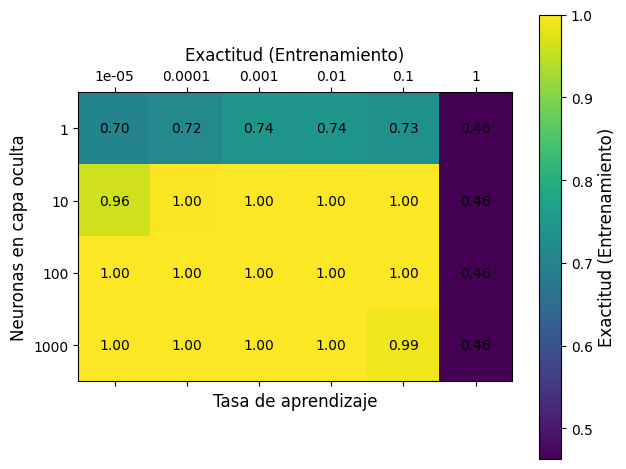

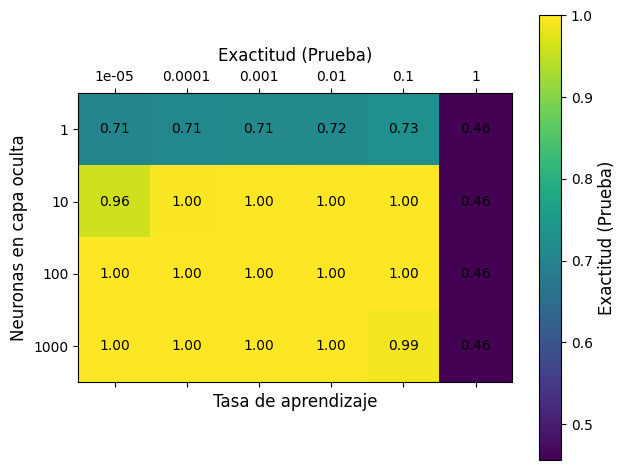

<ipython-input-13-bd44b28b8ae9>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + x)
<ipython-input-13-bd44b28b8ae9>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + y)


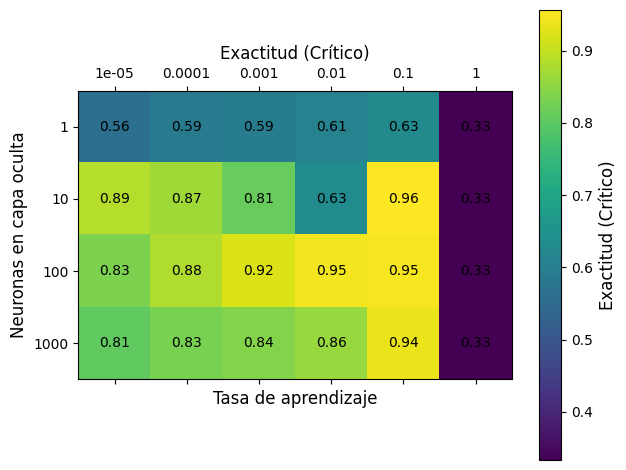

<ipython-input-13-bd44b28b8ae9>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + x)
<ipython-input-13-bd44b28b8ae9>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + y)


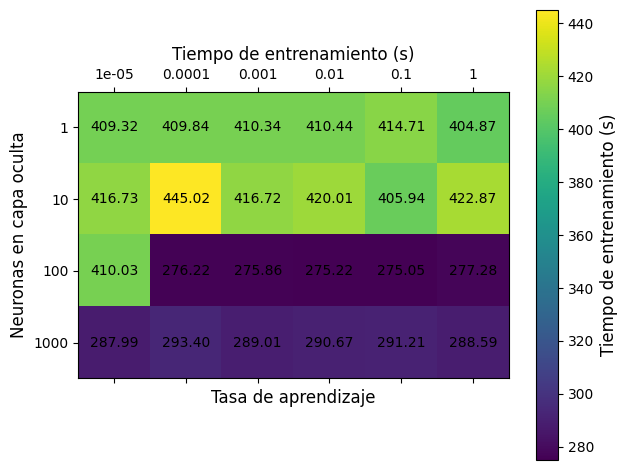

<ipython-input-13-bd44b28b8ae9>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + x)
<ipython-input-13-bd44b28b8ae9>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + y)


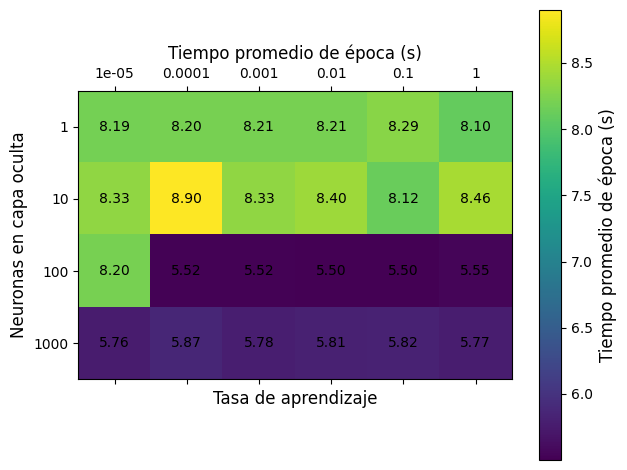

In [13]:
# Define una función para extraer datos de los resultados
def extract_data(results, metric):
    neurons = sorted(set(key[0] for key in results.keys())) # Obtiene los valores únicos de neuronas
    learning_rates = sorted(set(key[1] for key in results.keys())) # Obtiene los valores únicos de tasas de aprendizaje
    data_matrix = np.zeros((len(neurons), len(learning_rates))) # Crea una matriz para almacenar los datos

    # Llena la matriz con los valores de la métrica especificada
    for i, n in enumerate(neurons):
        for j, lr in enumerate(learning_rates):
            data_matrix[i, j] = results[(n, lr)][metric]

    return learning_rates, neurons, data_matrix # Devuelve los datos extraídos

# Define una función para graficar los datos
def plot_data(x, y, data, title=None):
    fontsize = 12

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest')

    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel(title, rotation=90, fontsize=fontsize)

    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = f"{data[j, i]:.2f}"
            ax.text(x_val, y_val, c, va='center', ha='center')

    x = [str(i) for i in x]
    y = [str(i) for i in y]

    ax.set_xticklabels([''] + x)
    ax.set_yticklabels([''] + y)

    ax.set_xlabel('Tasa de aprendizaje', fontsize=fontsize)
    ax.set_ylabel('Neuronas en capa oculta', fontsize=fontsize)
    if title is not None:
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

# Graficar los resultados para cada métrica
for metric in ['train_accuracy_1', 'test_accuracy_1', 'critical_accuracy_1']:
    learning_rates, neurons, data_matrix = extract_data(results_1, metric)

    # Cambiar los títulos de los gráficos
    if metric == 'train_accuracy_1':
        title = 'Exactitud (Entrenamiento)'
    elif metric == 'test_accuracy_1':
        title = 'Exactitud (Prueba)'
    elif metric == 'critical_accuracy_1':
        title = 'Exactitud (Crítico)'


    plot_data(learning_rates, neurons, data_matrix, title=title)

# Graficar el tiempo de entrenamiento
learning_rates, neurons, training_time_matrix = extract_data(results_1, 'training_time_1')
plot_data(learning_rates, neurons, training_time_matrix, title='Tiempo de entrenamiento (s)')

# Graficar el tiempo promedio de epoca
learning_rates, filters, average_epoch_time_matrix = extract_data(results_1, 'average_epoch_time_1')
plot_data(learning_rates, filters, average_epoch_time_matrix, title='Tiempo promedio de época (s)')


In [14]:
# Importa las bibliotecas para obtener información sobre el uso de recursos
import psutil
import resource

# Define funciones para obtener información sobre el uso de memoria, disco, CPU y recursos

def get_memory_usage():
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    return {
        'rss': memory_info.rss,
        'vms': memory_info.vms,
        'shared': memory_info.shared,
        'text': memory_info.text,
        'lib': memory_info.lib,
        'data': memory_info.data,
        'dirty': memory_info.dirty
    }

def get_disk_usage():
    disk_usage = psutil.disk_usage('/')
    return {
        'total': disk_usage.total,
        'used': disk_usage.used,
        'free': disk_usage.free,
        'percent': disk_usage.percent
    }

def get_cpu_usage():
    cpu_usage = psutil.cpu_percent(interval=1)
    return {
        'cpu_percent': cpu_usage
    }

def get_resource_usage():
    resource_usage = resource.getrusage(resource.RUSAGE_SELF)
    return {
        'utime': resource_usage.ru_utime,  # User CPU time used
        'stime': resource_usage.ru_stime,  # System CPU time used
        'maxrss': resource_usage.ru_maxrss,  # Maximum resident set size
        'ixrss': resource_usage.ru_ixrss,   # Integral shared memory size
        'idrss': resource_usage.ru_idrss,   # Integral unshared data size
        'isrss': resource_usage.ru_isrss,   # Integral unshared stack size
        'minflt': resource_usage.ru_minflt, # Page reclaims (soft page faults)
        'majflt': resource_usage.ru_majflt, # Page faults (hard page faults)
        'nswap': resource_usage.ru_nswap,   # Number of swaps
        'inblock': resource_usage.ru_inblock,  # Block input operations
        'oublock': resource_usage.ru_oublock,  # Block output operations
        'msgsnd': resource_usage.ru_msgsnd,  # IPC messages sent
        'msgrcv': resource_usage.ru_msgrcv,  # IPC messages received
        'nsignals': resource_usage.ru_nsignals, # Signals received
        'nvcsw': resource_usage.ru_nvcsw,    # Voluntary context switches
        'nivcsw': resource_usage.ru_nivcsw   # Involuntary context switches
    }

print("Memory Usage:", get_memory_usage())
print("Disk Usage:", get_disk_usage())
print("CPU Usage:", get_cpu_usage())
print("Resource Usage:", get_resource_usage())


Memory Usage: {'rss': 7643983872, 'vms': 28532965376, 'shared': 581332992, 'text': 2818048, 'lib': 0, 'data': 8415318016, 'dirty': 0}
Disk Usage: {'total': 216063848448, 'used': 29355507712, 'free': 186691563520, 'percent': 13.6}
CPU Usage: {'cpu_percent': 6.5}
Resource Usage: {'utime': 8174.556899, 'stime': 984.098368, 'maxrss': 13157928, 'ixrss': 0, 'idrss': 0, 'isrss': 0, 'minflt': 24563270, 'majflt': 2099, 'nswap': 0, 'inblock': 363064, 'oublock': 288, 'msgsnd': 0, 'msgrcv': 0, 'nsignals': 0, 'nvcsw': 110013822, 'nivcsw': 1449143}


In [39]:
# Encontrar el mejor resultado para cada conjunto de datos,
# utilizando la función max y una función lambda para especificar
# la métrica de comparación (accuracy).
best_train_result = max(results_1.items(), key=lambda item: item[1]['train_accuracy_1'])
best_test_result = max(results_1.items(), key=lambda item: item[1]['test_accuracy_1'])
best_critical_result = max(results_1.items(), key=lambda item: item[1]['critical_accuracy_1'])

# Imprimir los mejores resultados para cada conjunto de datos.
print("Mejor resultado para train:", best_train_result)
print("Mejor resultado para test:", best_test_result)
print("Mejor resultado para critical:", best_critical_result)

best_train_accuracy = best_train_result[1]['train_accuracy_1']
best_test_accuracy = best_test_result[1]['test_accuracy_1']
best_critical_accuracy = best_critical_result[1]['critical_accuracy_1']

# Extraer los valores de 'neurons' y 'lr' de los mejores resultados.
best_train_neurons, best_train_lr = best_train_result[0]
best_test_neurons, best_test_lr = best_test_result[0]
best_critical_neurons, best_critical_lr = best_critical_result[0]

# Imprimir los mejores hiperparámetros (neurons y lr) para cada conjunto de datos.
print("Mejor exactitud (entrenamiento) =", best_train_accuracy,"con hiperparámetros: número de neuronas =", best_train_neurons, "y lr =", best_train_lr)
print("Mejor exactitud (prueba) =", best_test_accuracy,"con hiperparámetros: número de neuronas =", best_test_neurons, "y lr =", best_test_lr)
print("Mejor exactitud (critico) =", best_critical_accuracy,"con hiperparámetros: número de neuronas =", best_critical_neurons, "y lr =", best_critical_lr)

Mejor resultado para train: ((10, 0.1), {'train_loss_1': 0.016139989718794823, 'train_accuracy_1': 1.0, 'test_loss_1': 0.01749628223478794, 'test_accuracy_1': 0.9993846416473389, 'critical_loss_1': 0.1455353945493698, 'critical_accuracy_1': 0.9562333226203918, 'average_epoch_time_1': 8.11875023841858, 'training_time_1': 405.9446747303009})
Mejor resultado para test: ((100, 0.01), {'train_loss_1': 1.9930607777496334e-06, 'train_accuracy_1': 1.0, 'test_loss_1': 1.2754282579408027e-05, 'test_accuracy_1': 1.0, 'critical_loss_1': 0.3700595200061798, 'critical_accuracy_1': 0.9450666904449463, 'average_epoch_time_1': 5.504354014396667, 'training_time_1': 275.2246205806732})
Mejor resultado para critical: ((10, 0.1), {'train_loss_1': 0.016139989718794823, 'train_accuracy_1': 1.0, 'test_loss_1': 0.01749628223478794, 'test_accuracy_1': 0.9993846416473389, 'critical_loss_1': 0.1455353945493698, 'critical_accuracy_1': 0.9562333226203918, 'average_epoch_time_1': 8.11875023841858, 'training_time_1':

In [53]:
def calcular_sobreajuste(train_accuracy, test_accuracy):
  """Calcula el porcentaje de sobreajuste.

  Args:
    train_accuracy: Precisión en los datos de entrenamiento.
    test_accuracy: Precisión en los datos de prueba o críticos.

  Returns:
    El porcentaje de sobreajuste.
  """
  overfitting = (train_accuracy - test_accuracy) / train_accuracy * 100
  return overfitting

In [57]:
train_accuracy_for_chosen_params = results_1[(10, 0.1)]['train_accuracy_1']
test_accuracy_for_chosen_params = results_1[(10, 0.1)]['test_accuracy_1']
critical_accuracy_for_chosen_params = results_1[(10, 0.1)]['critical_accuracy_1']
training_time_for_chosen_params = results_1[(10, 0.1)]['training_time_1']

print(f'Tiempo de entrenamiento para mejor modelo: {training_time_for_chosen_params} segundos')
print('Exactitud (entrenamiento) =', train_accuracy_for_chosen_params )
print('Exactitud (prueba) =', test_accuracy_for_chosen_params )
print('Exactitud (crítico) =', critical_accuracy_for_chosen_params)

sobreajuste_test = calcular_sobreajuste(train_accuracy_for_chosen_params, test_accuracy_for_chosen_params)
sobreajuste_critico = calcular_sobreajuste(train_accuracy_for_chosen_params, critical_accuracy_for_chosen_params)

print(f"Porcentaje de sobreajuste (prueba): {sobreajuste_test:.2f}%")
print(f"Porcentaje de sobreajuste (crítico): {sobreajuste_critico:.2f}%")

Tiempo de entrenamiento para mejor modelo: 405.9446747303009 segundos
Exactitud (entrenamiento) = 1.0
Exactitud (prueba) = 0.9993846416473389
Exactitud (crítico) = 0.9562333226203918
Porcentaje de sobreajuste (prueba): 0.06%
Porcentaje de sobreajuste (crítico): 4.38%


In [22]:
test_accuracy_for_chosen_params = results_1[(10, 0.1)]['test_accuracy_1']

print("Mejor exactitud (entrenamiento) =", best_train_accuracy,"con hiperparámetros: número de neuronas =", best_train_neurons, "y lr =", best_train_lr)
print("exactitud (prueba) =", test_accuracy_for_chosen_params,"con hiperparámetros: número de neuronas =", best_train_neurons, "y lr =", best_train_lr)
print("Mejor exactitud (critico) =", best_critical_accuracy,"con hiperparámetros: número de neuronas =", best_critical_neurons, "y lr =", best_critical_lr)

Mejor exactitud (entrenamiento) = 1.0 con hiperparámetros: número de neuronas = 10 y lr = 0.1
exactitud (prueba) = 0.9993846416473389 con hiperparámetros: número de neuronas = 10 y lr = 0.1
Mejor exactitud (entrenamiento) = 0.9562333226203918 con hiperparámetros: número de neuronas = 10 y lr = 0.1


In [23]:
chosen_neurons = best_train_neurons
chosen_lr = best_train_lr

# SEGUNDA ETAPA

In [35]:
# Define una función para construir el modelo

from tensorflow.keras import regularizers

def build_model_2(input_dim, neurons, learning_rate, lmbda):
    model = Sequential()
    # Agrega una capa densa con activación ReLU y regularización L2.
    model.add(Dense(neurons, input_dim=input_dim, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42), kernel_regularizer=regularizers.l2(lmbda)))
     # Agrega una capa de dropout para prevenir el sobreajuste.
    model.add(Dropout(0.5, seed=42))
    # Agrega una capa de salida con activación softmax para clasificación binaria.
    model.add(Dense(2, activation='softmax'))


    # Define el optimizador SGD con momentum.
    optimizer = SGD(learning_rate=learning_rate, momentum = 0.5)
    # Compila el modelo con la función de pérdida de entropía cruzada categórica y la métrica de precisión.
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [36]:
# Define una función para evaluar el modelo
def evaluate_model_2(neurons, learning_rate, lmbda, verbose=True):
    model = build_model_2(X_train.shape[1], neurons, learning_rate, lmbda) # Construye el modelo

    # Limpiar la sesión de Keras para liberar memoria
    tf.keras.backend.clear_session()

    epoch_times = []  # Lista para almacenar los tiempos de cada época

    start_totaltime = time.time()  # Registrar el tiempo de inicio
    for epoch in range(50):
        start_time = time.time()  # Registrar el tiempo de inicio de la época
        model.fit(train_dataset, epochs=1, batch_size=64, verbose=verbose)  # Entrenar por una época
        epoch_time = time.time() - start_time  # Calcular el tiempo de la época
        epoch_times.append(epoch_time)
        if verbose:
            print(f'Epoch {epoch+1} time: {epoch_time} seconds')

    training_time = time.time() - start_totaltime  # Calcular el tiempo de entrenamiento

    average_epoch_time = sum(epoch_times) / len(epoch_times)  # Calcular el promedio

    # Evalúa el modelo en los conjuntos de entrenamiento y prueba
    train_loss, train_accuracy = model.evaluate(X_train, Y_train, verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)

    if verbose:
        print(f'Train loss: {train_loss}, Train accuracy: {train_accuracy}')
        print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')
        print(f'Average epoch time: {average_epoch_time} seconds')
        print(f'Training time: {training_time} seconds')


    # Devuelve las métricas de evaluación y los tiempos
    return train_loss, train_accuracy, test_loss, test_accuracy, average_epoch_time, training_time

In [37]:
def lambda_search(verbose=True):
    N_neurons = chosen_neurons
    learning_rate = chosen_lr
    lambdas= [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e+00, 1e+1, 1e+2, 1e+3, 1e+4, 1e+5]  # Valores de tasas de aprendizaje

    results_2 = {}

    for lmbda in lambdas:
            print(f'Training DNN with lambda = {lmbda}')

            # Evalúa el modelo con el lambda actual
            train_loss_2, train_accuracy_2, test_loss_2, test_accuracy_2, average_epoch_time_2, training_time_2 = evaluate_model_2(N_neurons, learning_rate, lmbda, verbose)

            # Guarda los resultados
            results_2[(lmbda)] = {
                'train_loss_2': train_loss_2,
                'train_accuracy_2': train_accuracy_2,
                'test_loss_2': test_loss_2,
                'test_accuracy_2': test_accuracy_2,
                'average_epoch_time_2': average_epoch_time_2,
                'training_time_2': training_time_2
            }

    return results_2


In [38]:
# Ejecutar lambda_search y guardar los resultados
results_2 = lambda_search()

Training DNN with lambda = 1e-05
1625/1625 [==============================] - 11s 7ms/step - loss: 0.2082 - accuracy: 0.9547
Epoch 1 time: 12.039247751235962 seconds
1625/1625 [==============================] - 8s 5ms/step - loss: 0.1026 - accuracy: 0.9769
Epoch 2 time: 8.002949953079224 seconds
1625/1625 [==============================] - 9s 6ms/step - loss: 0.0911 - accuracy: 0.9788
Epoch 3 time: 9.109331607818604 seconds
1625/1625 [==============================] - 9s 5ms/step - loss: 0.0867 - accuracy: 0.9795
Epoch 4 time: 8.926597356796265 seconds
1625/1625 [==============================] - 8s 5ms/step - loss: 0.0877 - accuracy: 0.9789
Epoch 5 time: 8.453333854675293 seconds
1625/1625 [==============================] - 8s 5ms/step - loss: 0.0879 - accuracy: 0.9787
Epoch 6 time: 7.618337154388428 seconds
1625/1625 [==============================] - 9s 5ms/step - loss: 0.0859 - accuracy: 0.9793
Epoch 7 time: 8.658997535705566 seconds
1625/1625 [==============================] - 9s 

In [40]:
print(results_2)

{1e-05: {'train_loss_2': 0.021125920116901398, 'train_accuracy_2': 1.0, 'test_loss_2': 0.021914182230830193, 'test_accuracy_2': 0.9996923208236694, 'average_epoch_time_2': 8.710188212394714, 'training_time_2': 435.5158808231354}, 0.0001: {'train_loss_2': 0.024475019425153732, 'train_accuracy_2': 0.9997019171714783, 'test_loss_2': 0.02598024718463421, 'test_accuracy_2': 0.9992692470550537, 'average_epoch_time_2': 8.581955137252807, 'training_time_2': 429.1051163673401}, 0.001: {'train_loss_2': 0.03754391148686409, 'train_accuracy_2': 1.0, 'test_loss_2': 0.03702275827527046, 'test_accuracy_2': 1.0, 'average_epoch_time_2': 8.682939944267273, 'training_time_2': 434.15315079689026}, 0.01: {'train_loss_2': 0.15567710995674133, 'train_accuracy_2': 0.9995673298835754, 'test_loss_2': 0.15368770062923431, 'test_accuracy_2': 0.9994615316390991, 'average_epoch_time_2': 6.806784830093384, 'training_time_2': 340.34765219688416}, 0.1: {'train_loss_2': 0.242388516664505, 'train_accuracy_2': 0.99930769

In [41]:
# Extrae los resultados para graficar
train_accuracy_2 = [results_2[lmbda]['train_accuracy_2'] for lmbda in results_2]
test_accuracy_2 = [results_2[lmbda]['test_accuracy_2'] for lmbda in results_2]
training_time_2 = [results_2[lmbda]['training_time_2'] for lmbda in results_2]
average_epoch_time_2 = [results_2[lmbda]['average_epoch_time_2'] for lmbda in results_2]
lambdas = list(results_2.keys()) # Los valores de lambda usados

In [42]:
print(train_accuracy_2)
print(test_accuracy_2)

[1.0, 0.9997019171714783, 1.0, 0.9995673298835754, 0.9993076920509338, 0.537086546421051, 0.537086546421051, 0.462913453578949, 0.462913453578949, 0.462913453578949, 0.462913453578949]
[0.9996923208236694, 0.9992692470550537, 1.0, 0.9994615316390991, 0.9993076920509338, 0.5439615249633789, 0.5439615249633789, 0.4560384750366211, 0.4560384750366211, 0.4560384750366211, 0.4560384750366211]


In [47]:
best_train_index_2 = np.argmax(train_accuracy_2)
best_test_index_2 = np.argmax(test_accuracy_2)

best_lambda_train = lambdas[best_train_index_2]
best_lambda_test = lambdas[best_test_index_2]

best_train_accuracy = train_accuracy_2[best_train_index_2]
best_training_time = training_time_2[best_train_index_2]
best_avg_epoch_time = average_epoch_time_2[best_train_index_2]
best_test_accuracy = test_accuracy_2[best_test_index_2]



print(f"Mejor exactitud (entrenamiento) = {train_accuracy_2[best_train_index_2]}, con lambda = {best_lambda_train}, tiempo de entrenamiento = {best_training_time}")
print(f"Mejor exactitud (prueba) = {test_accuracy_2[best_test_index_2]}, con lambda =  {best_lambda_test}")

print(f"Exactitud (entrenamiento) = {train_accuracy_2[best_test_index_2]}, con lambda =  {best_lambda_test}, tiempo de entrenamiento = {training_time_2[best_test_index_2]}")

Mejor exactitud (entrenamiento) = 1.0, con lambda = 1e-05, tiempo de entrenamiento = 435.5158808231354
Mejor exactitud (prueba) = 1.0, con lambda =  0.001
Exactitud (entrenamiento) = 1.0, con lambda =  0.001, tiempo de entrenamiento = 434.15315079689026


In [48]:
chosen_lambda = best_lambda_test

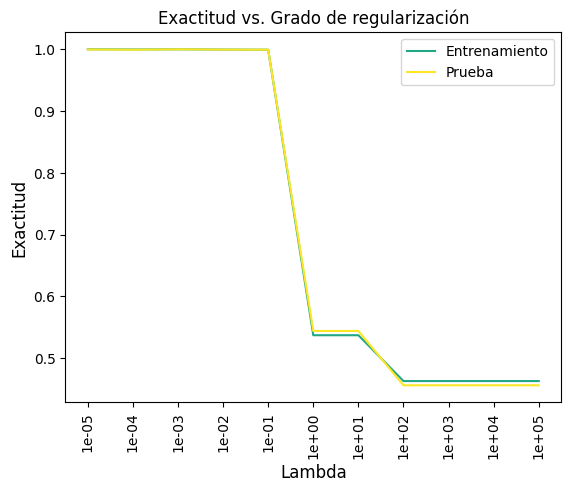

In [55]:
import matplotlib.pyplot as plt

# Grafica la precisión de entrenamiento y prueba contra lambda
plt.xscale('log')
plt.xticks(lambdas, [f'{lmbda:.0e}' for lmbda in lambdas], rotation=90)
plt.plot(lambdas, train_accuracy_2, '#21a784', label='Entrenamiento')
plt.plot(lambdas, test_accuracy_2, '#fde624',label='Prueba')
plt.xlabel('Lambda', fontsize=12)
plt.ylabel('Exactitud', fontsize=12)
plt.title('Exactitud vs. Grado de regularización')
plt.legend()
plt.show()

# MEJOR MODELO

In [50]:
# Construir y entrenar el modelo con el mejor lambda
best_model = build_model_2(X_train.shape[1], chosen_neurons, chosen_lr, chosen_lambda)    #build_model_2(input_dim, neurons, learning_rate, lmbda):

# Ajusta el modelo con los datos de entrenamiento
start_time_best = time.time()
best_model.fit(train_dataset, epochs=50, batch_size=64)
training_time_best = time.time() - start_time_best

Epoch 1/50
1625/1625 [==============================] - 12s 7ms/step - loss: 0.1589 - accuracy: 0.9624
Epoch 2/50
1625/1625 [==============================] - 9s 5ms/step - loss: 0.1090 - accuracy: 0.9733
Epoch 3/50
1625/1625 [==============================] - 10s 6ms/step - loss: 0.1027 - accuracy: 0.9747
Epoch 4/50
1625/1625 [==============================] - 9s 6ms/step - loss: 0.1013 - accuracy: 0.9748
Epoch 5/50
1625/1625 [==============================] - 9s 6ms/step - loss: 0.1054 - accuracy: 0.9733
Epoch 6/50
1625/1625 [==============================] - 10s 6ms/step - loss: 0.1016 - accuracy: 0.9744
Epoch 7/50
1625/1625 [==============================] - 11s 7ms/step - loss: 0.1043 - accuracy: 0.9738
Epoch 8/50
1625/1625 [==============================] - 9s 6ms/step - loss: 0.1015 - accuracy: 0.9745
Epoch 9/50
1625/1625 [==============================] - 9s 6ms/step - loss: 0.0992 - accuracy: 0.9753
Epoch 10/50
1625/1625 [==============================] - 7s 5ms/step - loss: 0

In [51]:
# Evaluar el modelo en el conjunto de entrenamiento
train_loss_bestmodel, train_accuracy_bestmodel = best_model.evaluate(X_train, Y_train, verbose=0)

# Evaluar el modelo en el conjunto de prueba
test_loss_bestmodel, test_accuracy_bestmodel = best_model.evaluate(X_test, Y_test, verbose=0)

# Evaluar el modelo en el conjunto crítico
critical_loss_bestmodel, critical_accuracy_bestmodel = best_model.evaluate(X_critical, Y_critical, verbose=0)

In [52]:
print(f'Tiempo de entrenamiento para best_model: {training_time_best} segundos')
print('Exactitud (entrenamiento) =', train_accuracy_bestmodel )
print('Exactitud (prueba) =', test_accuracy_bestmodel )
print('Exactitud (crítico) =', critical_accuracy_bestmodel)

Tiempo de entrenamiento para best_model: 490.7993507385254 segundos
Exactitud (entrenamiento) = 0.9999615550041199
Exactitud (prueba) = 0.9999615550041199
Exactitud (crítico) = 0.9609000086784363


In [54]:
sobreajuste_test = calcular_sobreajuste(train_accuracy_bestmodel, test_accuracy_bestmodel)
sobreajuste_critico = calcular_sobreajuste(train_accuracy_bestmodel, critical_accuracy_bestmodel)

print(f"Porcentaje de sobreajuste (prueba): {sobreajuste_test:.2f}%")
print(f"Porcentaje de sobreajuste (crítico): {sobreajuste_critico:.2f}%")

Porcentaje de sobreajuste (prueba): 0.00%
Porcentaje de sobreajuste (crítico): 3.91%
